In [1]:
import lsst.daf.butler as dafButler
import lsst.daf.persistence as dafPersistence
import numpy as np
import pandas as pd
from collections import Counter
import astropy
import astropy.coordinates
import matplotlib
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# Fred Moolekamp's matching function
def matchSources(catalog, refcat, separation=1*astropy.units.arcsec, refcuts=True):
    # Create coordinates for sources
    coords = astropy.coordinates.SkyCoord(catalog["coord_ra"], catalog["coord_dec"], unit="rad")
    # Create coordinates for truth catalog sources
    refCoords = astropy.coordinates.SkyCoord(refcat["ra"], refcat["dec"], unit="deg")
    
    # Match all sources up to separation
    coordIdx, dist, _ = astropy.coordinates.match_coordinates_sky(coords, refCoords)
    distCuts = dist < separation
    matched = catalog[distCuts]
    coordIdx = coordIdx[distCuts]
    matchedRef = refcat[coordIdx]

    # Keep track of sources with no matches
    unmatched = coords[~distCuts]
    
    # Remove duplicates
    indices, invIndices, count = np.unique(matchedRef["id"], return_inverse=True, return_counts=True)
    countCuts = count[invIndices] == 1
    duplicates = matched[~countCuts]
    matched = matched[countCuts]
    matchedRef = matchedRef[countCuts]
    
    return (
        matched,
        matchedRef,
        dist[distCuts],
        unmatched,
        duplicates
    )

In [3]:
truth_cat_pathname = "/project/hchiang2/qserv/dc2_dr6/truth_match_v2_public/truth_tract3828.parquet"
truth_cat = pd.read_parquet(truth_cat_pathname)
truth_cat.head()

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry
0,7816513885,-1,57.503538,-37.189842,1.270010,0,0,246.984558,234.669754,214.219315,...,"0,0",1,9812,7816513885,25.572853,16835722044507628,0.049484,True,True,True
1,7812675090,-1,57.451876,-37.189982,0.344580,0,0,31.958035,60.569202,131.726593,...,"0,0",1,9812,7812675090,26.100817,16835722044507640,0.234430,True,True,True
2,7814647934,-1,57.506052,-37.189499,0.990622,0,0,65.868942,80.165848,122.161423,...,"0,0",1,9812,7814647934,26.182667,16835722044507645,0.215764,True,True,True
3,7814197393,-1,57.529435,-37.189048,0.892836,0,0,66.701424,88.351448,162.388611,...,"0,0",1,9812,7814197393,25.873611,16835722044507650,0.032703,True,True,True
4,7813507782,-1,57.407629,-37.189873,0.697208,0,0,17.108637,28.560108,67.255020,...,"0,0",1,9812,7813507782,26.830688,16835722044507655,0.208699,False,True,True


In [4]:
red_cat = astropy.io.fits.open("/project/erykoff/gaap_error_testing/cosmodc2_1.1.4_redmapper_v0.8.0_redgals.fits")[1].data
tract_cut = (red_cat['ra']>=truth_cat['ra'].min())&(red_cat['ra']<=truth_cat['ra'].max())&(red_cat['dec']>=truth_cat['dec'].min())&(red_cat['dec']<=truth_cat['dec'].max())

In [5]:
runName = "2.2i/runs/test-med-1/w_2021_28/DM-31044"
butler = dafButler.Butler("/repo/dc2", run=runName)

In [6]:
# "u/kannawad/june21-scipipe-sprint/20210622T042849Z" has 20-29
collections = ["u/kannawad/june21-scipipe-sprint/20210619T225911Z",
               "u/kannawad/june21-scipipe-sprint/20210622T052648Z",
               "u/kannawad/june21-scipipe-sprint/20210622T151909Z",
               "u/kannawad/june21-scipipe-sprint/20210630T174054Z",
               "u/kannawad/june21-scipipe-sprint/20210702T010817Z",
               "u/kannawad/june21-scipipe-sprint/20210701T213012Z",
               "u/kannawad/june21-scipipe-sprint/20210707T010507Z",
               "u/kannawad/june21-scipipe-sprint/20210712T191847Z",
              ]
# butler = dafButler.Butler("repo/dc2", run="u/kannawad/june21-scipipe-sprint", collections=collections)

In [24]:
objTable = butler.get("objectTable", tract=3828, patch=5)

# Check that it has all 49 patches
assert len(Counter(objTable['patch']))==1

In [25]:
# Have a look at the GAaP columns
gaapNames = [nam for nam in list(objTable.columns) if 'gaap' in nam.lower()]
objTable[gaapNames]

column,yGaapFlux_Psf,yGaapFluxErr_Psf,yGaapFlux_0_7,yGaapFluxErr_0_7,yGaapFlux_1_0,yGaapFluxErr_1_0,yGaapFlux_Optimal,yGaapFluxErr_Optimal,yGaapFlux_Psf_apCorr,yGaapFlux_Psf_apCorrErr,...,uGaapFlux_0_7_apCorr,uGaapFlux_0_7_apCorrErr,uGaapFlux_1_0_apCorr,uGaapFlux_1_0_apCorrErr,uGaapFlux_flag,uGaapFlux_flag_edge,uGaapFlux_flag_gaussianization,uGaapFlux_Optimal_flag_bigPsf,uGaapFlux_0_7_flag_bigPsf,uGaapFlux_1_0_flag_bigPsf
id,,,,,,,,,,,,,,,,,,,,,
1649944740826710017,NaN,NaN,1097.106573,234.543999,1279.490961,270.637361,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649944740826710018,NaN,NaN,4203.868140,245.948148,4715.549381,283.797391,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649944740826710019,NaN,NaN,1129.071452,234.155266,1088.380691,270.383336,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649944740826710020,NaN,NaN,186.276659,219.796487,336.014027,253.505555,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649944740826710021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649944740826750960,NaN,NaN,303.506471,242.763626,328.978640,279.072745,295.125091,252.073830,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649944740826750961,NaN,NaN,11.331810,243.610717,30.577200,279.336886,8.705677,252.217584,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1649944740826750962,NaN,NaN,3.948206,251.341122,94.030422,288.970555,-2.683069,257.508745,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
obj = objTable
np.nanmean(obj['zGaapFlux_Psf_apCorr'])

<ipython-input-9-2c5de701e311>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(obj['zGaapFlux_Psf_apCorr'])


nan

Before matching the object table with the truth table, visually check the matching 

<IPython.core.display.Javascript object>


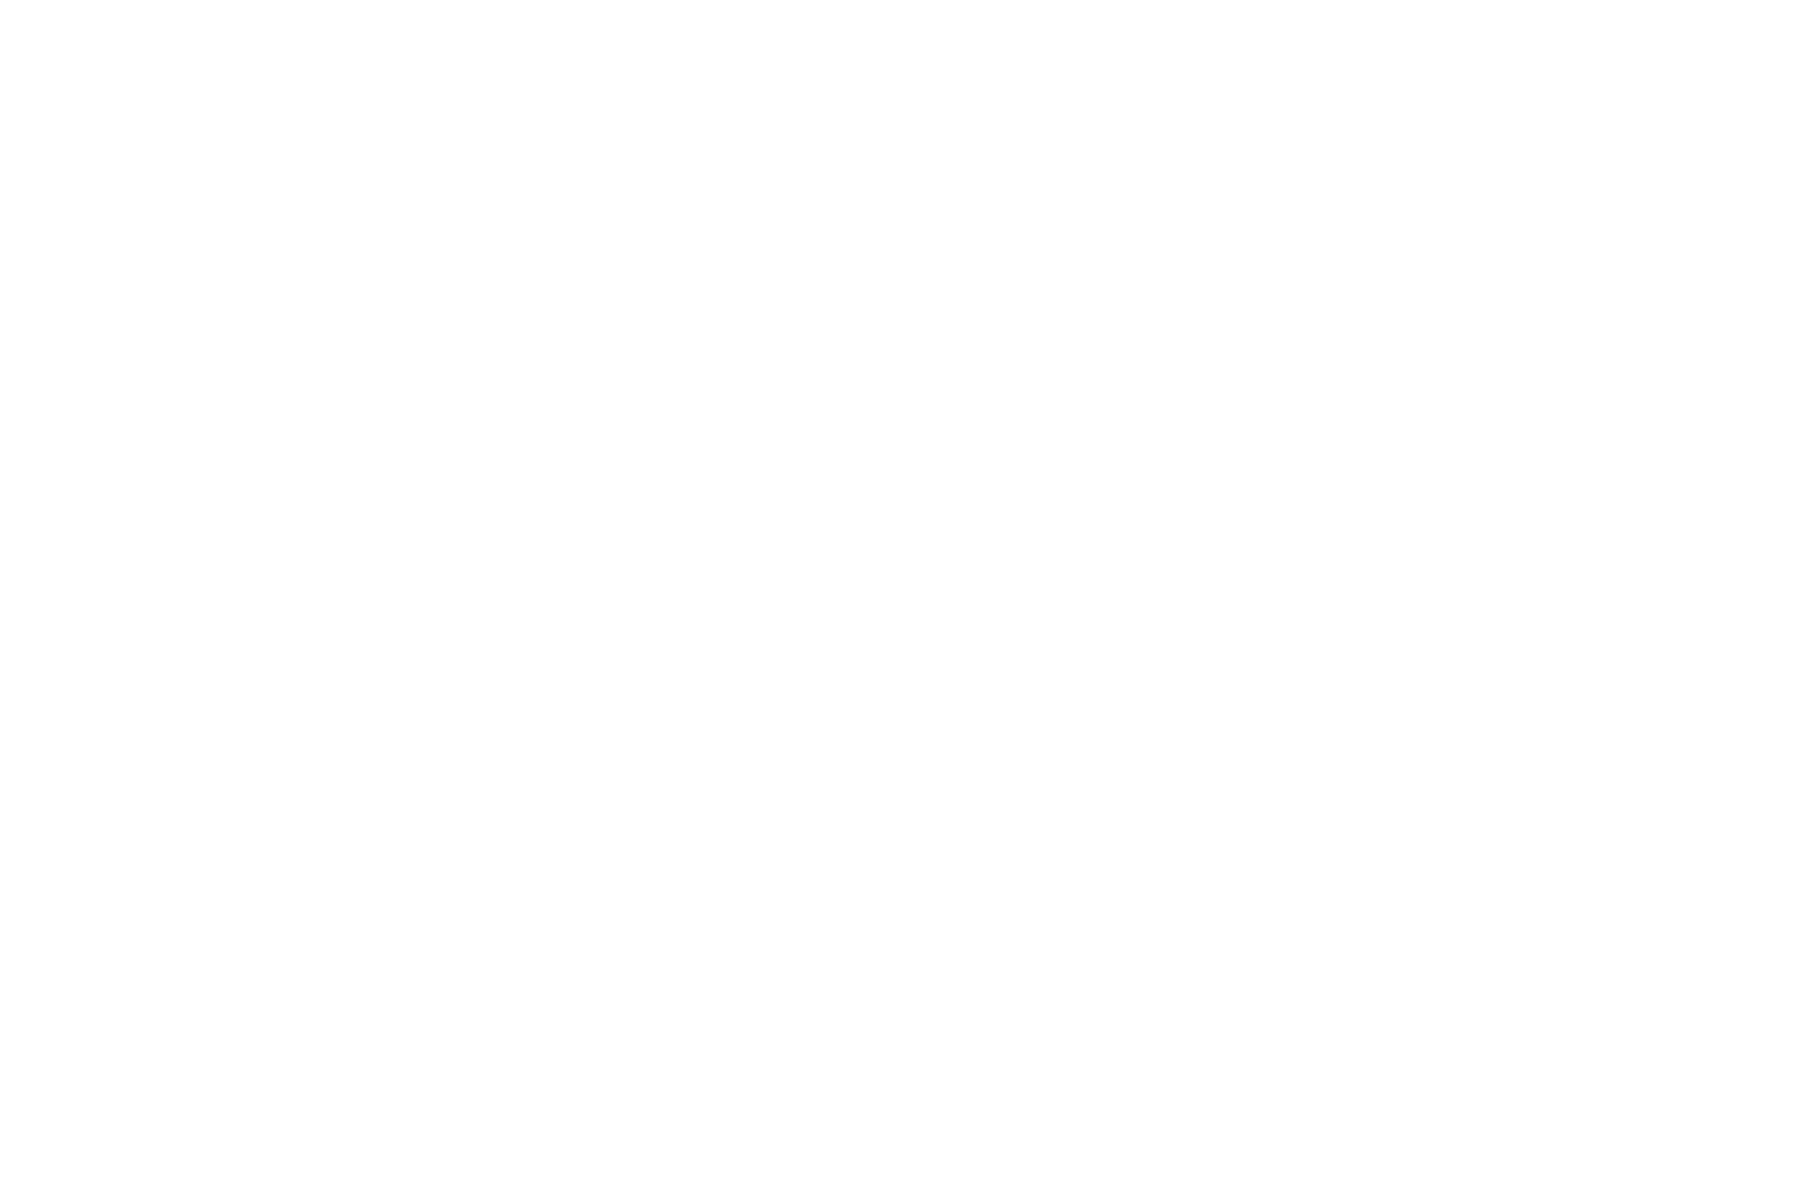

Number of true objects =  4645755
Number of detected objects =  1455735
55.673774112824596 57.62575087064195 -37.22367474262323 -35.66512168721033
Number of detected objects =  4830
55.73666565730402 57.56325172313701 -37.19006390175687 -35.70257285604437


In [26]:
fig, ax = plt.subplots()
fig.set_size_inches([9, 6])
ra_min, ra_max = 56.69, 56.71
dec_min, dec_max = -36.71, -36.69
ra_min, ra_max = 56.10, 56.15
dec_min, dec_max = -36.90, -35.82
ra_min, ra_max = -np.inf, np.inf
dec_min, dec_max = -np.inf, np.inf
cuts = (truth_cat['ra']>ra_min)&(truth_cat['ra']<ra_max)&(truth_cat['dec']>dec_min)&(truth_cat['dec']<dec_max)
print("Number of true objects = ", cuts.sum())
#ax.plot(truth_cat['ra'][cuts], truth_cat['dec'][cuts], 'o', fillstyle='none', color='C0')

x, y = obj['coord_ra'], obj['coord_dec'] #*180./np.pi
cuts = (x>ra_min)&(x<ra_max)&(y>dec_min)&(y<dec_max)
print("Number of detected objects = ", cuts.sum())
print(x.min(), x.max(), y.min(), y.max())
ax.plot(x[cuts], y[cuts], '.', color='C1',alpha=0.9)

#Red galaxies
x, y = red_cat[tract_cut]['ra'], red_cat[tract_cut]['dec'] #*180./np.pi
cuts = (x>ra_min)&(x<ra_max)&(y>dec_min)&(y<dec_max)
print("Number of detected objects = ", cuts.sum())
print(x.min(), x.max(), y.min(), y.max())
ax.plot(x[cuts], y[cuts], 'x', color='r',alpha=0.9)

Convert the coordinates to astropy format and match

In [11]:
%%time
truth_coord = astropy.coordinates.SkyCoord(truth_cat['ra'], truth_cat['dec'], unit='deg')
red_coord = astropy.coordinates.SkyCoord(red_cat['ra'], red_cat['dec'], unit='deg')
meas_coord = astropy.coordinates.SkyCoord(obj['coord_ra'], obj['coord_dec'], unit='deg')

CPU times: user 2min 25s, sys: 3.46 s, total: 2min 29s
Wall time: 2min 29s


In [31]:
print(meas_coord.shape, red_coord[tract_cut].shape)
idx, dist2d, dist3d = astropy.coordinates.match_coordinates_sky(red_coord[tract_cut], meas_coord)

(1455735,) (4830,)


In [12]:
idx, dist2d, dist3d = astropy.coordinates.match_coordinates_sky(truth_coord, red_coord[tract_cut])
# matched_meas = {}
# for band in ('g',):
#    matched_meas[band], truth_matched, _dist, _unmatched, _dup = matchSources(meas_dict[band], truth_cat)

Number of objects =  4830
Number of objects < 0.1, 1 arcsec = 4570.00, 4791.00


<IPython.core.display.Javascript object>


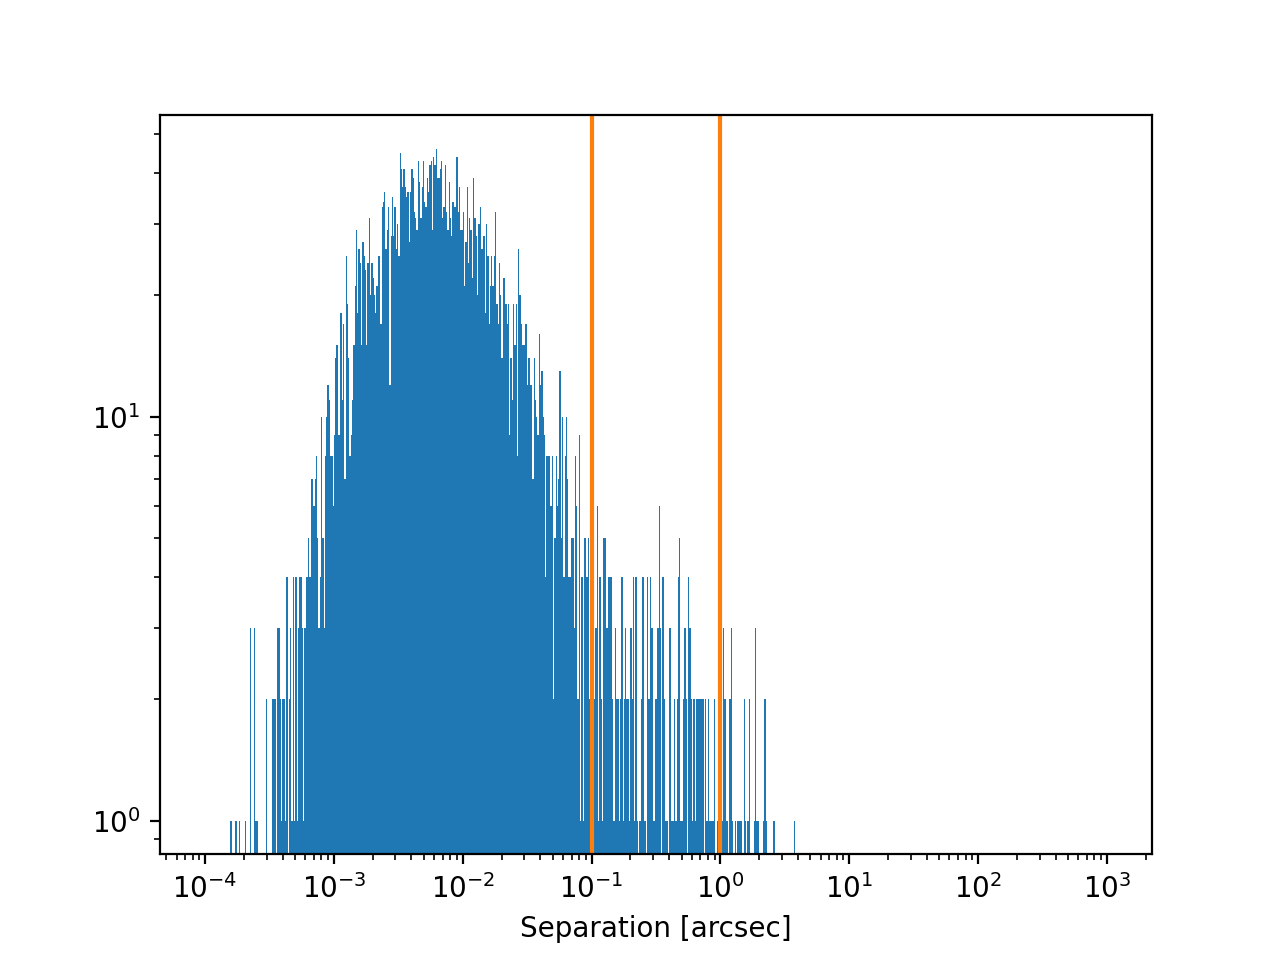

Text(0.5, 0, 'Separation [arcsec]')

In [32]:
print("Number of objects = ", len(idx))
print("Number of objects < 0.1, 1 arcsec = %.2f, %.2f" % ((dist2d.arcsec<0.1).sum(), (dist2d.arcsec<1.0).sum()))
bins = np.logspace(-4, 3,701)
_ = plt.hist(dist2d.arcsec, bins=bins)
plt.axvline(0.1, color='C1')
plt.axvline(1.0, color='C1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Separation [arcsec]")

In [105]:
red_cat.names

['id',
 'ra',
 'dec',
 'refmag',
 'refmag_err',
 'mag',
 'mag_err',
 'ztrue',
 'm200',
 'central',
 'halo_id',
 'ebv',
 'zred',
 'zred_e',
 'zred2',
 'zred2_e',
 'zred_uncorr',
 'zred_uncorr_e',
 'zred_samp',
 'lkhd',
 'chisq']

In [72]:
duplicate_cntr = Counter(idx[dist2d.arcsec<0.1])
duplicates = [(k,v) for k,v in duplicate_cntr.items() if v>1]
print(len(duplicates), len(duplicate_cntr), len(idx), (dist2d.arcsec<1).sum())

3741 5081 1455735 10115


In [73]:
# isUnique is True if idx occurs only once after filtering out by dist2d
isUnique = np.isin(idx, [k for k,v in Counter(idx[dist2d.arcsec<1]).items() if v==1], assume_unique=False)
isPointSource = np.array(truth_cat['is_pointsource'][idx], dtype=bool)
isVariable = np.array(truth_cat['is_variable'][idx], dtype=bool)
clean = isUnique & (dist2d.arcsec<1)
clean.sum(), isPointSource.sum(), (clean & isPointSource).sum()

(1297, 26447, 19)

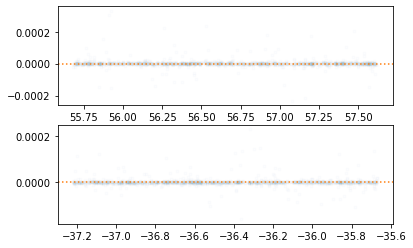

In [74]:
fig, ax = plt.subplots(2)
cuts = isUnique & (dist2d.arcsec<1)
ax[0].plot(truth_coord.ra[idx][clean], meas_coord.ra[clean]-truth_coord.ra[idx][clean], '.', alpha=0.01)
ax[1].plot(truth_coord.dec[idx][clean], meas_coord.dec[clean]-truth_coord.dec[idx][clean], '.', alpha=0.01)
for _ax in ax:
    _ax.axhline(0.0, color='C1', ls=':')

(-0.05, 0.05)

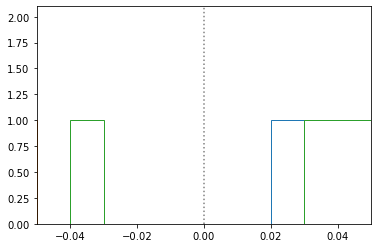

In [75]:
fig, ax = plt.subplots()
cuts = isUnique & (dist2d.arcsec<1) * isPointSource
bins = np.linspace(-1, 1, 201)
for gaapName in ('GaapFlux_Optimal', 'CModelFlux', 'PsFlux'):
    meas_color = -2.5*np.log10(objTable[cuts]['g'+gaapName].array/objTable[cuts]['r'+gaapName].array)
    true_color = -2.5*np.log10(truth_cat['flux_g'][idx][cuts]/truth_cat['flux_r'][idx][cuts])
    _ = ax.hist(meas_color-true_color, bins=bins, histtype='step', label=gaapName)

ax.axvline(0.0, color='gray', ls=':')
ax.set_xlim([-0.05,0.05])
# ax.set_yscale('log')
# ax.legend(loc='best')

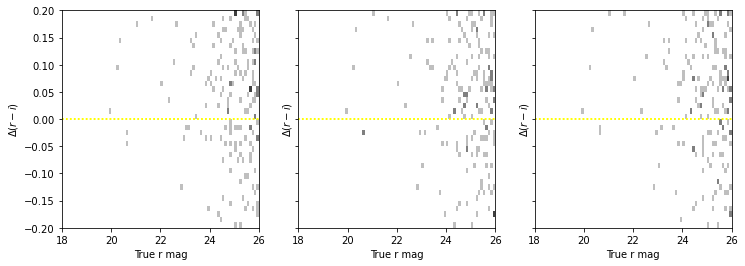

In [76]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True)
fig.set_size_inches([12,4])
xmin, xmax = 18,26
ymin, ymax = -0.2, 0.2
for gid, gaapName in enumerate(( 'CModelFlux', 'GaapFlux_1_0', 'GaapFlux_Optimal')):
    cuts = isUnique & (~isPointSource) & (dist2d.arcsec<1) #& (~obj['g'+gaapName.replace('_instFlux','_flag')]) & (~meas_dict['r'][gaapName.replace('_instFlux','_flag')])
    X = -2.5*np.log10(truth_cat['flux_r'][idx][cuts]) + 30.4
    gr_meas = -2.5*np.log10(obj[cuts]['r'+gaapName].array/obj[cuts]['i'+gaapName].array)
    gr_true = -2.5*np.log10(truth_cat['flux_r'][idx][cuts]/truth_cat['flux_i'][idx][cuts])
    #ax[gid].plot(X, gr_meas-gr_true,'.', alpha=0.01, label=gaapName.replace('Flux', ''))
    bins = np.arange(18,29,0.1), np.arange(-3.5,3.5,0.01)
    ax[gid].hist2d(X, gr_meas-gr_true, bins=bins, range= [[xmin, xmax], [ymin, ymax]], cmap=cm.gray_r)
    for _ax in ax:
        #_ax.set_title(f"{cuts.sum()} / {len(idx)}")
        _ax.axhline(0.0, color='yellow', ls=':')
        _ax.set_xlabel('True r mag')
        _ax.set_ylim([ymin, ymax])
        _ax.set_xlim([xmin, xmax])
        _ax.set_ylabel(r'$\Delta (r-i)$')
        

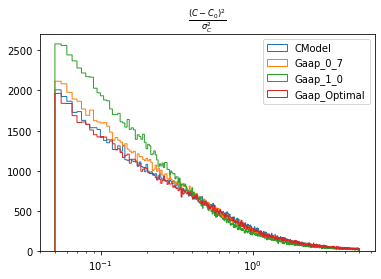

In [34]:
def errName(gaapName):
    if 'GaapFlux' in gaapName:
        return gaapName.replace('GaapFlux', 'GaapFluxErr')
    else:
        return gaapName+'Err'

fig, ax = plt.subplots(1)
# fig.set_size_inches([12,12])
bins = np.linspace(0.05, 5, 1001)
for gid, gaapName in enumerate(( 'CModelFlux', 'GaapFlux_0_7', 'GaapFlux_1_0', 'GaapFlux_Optimal')):
    cuts = isUnique & (~isPointSource) & (dist2d.arcsec<1) #& (~obj['g'+gaapName.replace('_instFlux','_flag')]) & (~meas_dict['r'][gaapName.replace('_instFlux','_flag')])
    X = -2.5*np.log10(truth_cat['flux_i'][idx][cuts]) + 30.4
    
    gr_meas =  obj[cuts]['g'+gaapName].array/obj[cuts]['r'+gaapName].array
    gr_true = truth_cat['flux_g'][idx][cuts]/truth_cat['flux_r'][idx][cuts]
    
    chi2 = ( gr_meas - gr_true )
    chi2err = (np.abs(obj[cuts]['g'+errName(gaapName)].array * obj[cuts]['r'+gaapName].array) + np.abs(obj[cuts]['r'+errName(gaapName)].array * obj[cuts]['g'+gaapName].array))/obj[cuts]['r'+gaapName].array**2
    
    Y = (chi2/chi2err)**2
    ax.hist(Y, bins=bins, histtype='step', label=gaapName.replace('Flux', ''))
    if gid==14:
        ax[1].plot(X, Y, '.', alpha=0.1, label=gaapName.replace('Flux', ''))
    #_ax.set_title(f"{cuts.sum()} / {len(idx)}")
    #ax.axhline(0.0, color='k', ls=':')
    #ax.set_xlabel('True i mag')
    #ax.set_ylim([-3.5, 3.5])
    #ax.set_xlim([18,29])
    #ax.set_ylabel(r'$\Delta (g-r)$')
    ax.set_xscale('log')
    ax.set_title(r"$\frac{(C-C_0)^2}{\sigma_C^2}$", rotation=0)
    # ax.set_ylim([-0.5,20])
    ax.legend(loc='best')
    # ax[1].legend(loc='best')
        

In [324]:
butl = dafButler.Butler("/repo/dc2", collections="2.2i/runs/test-med-1/")
for tract in range(2553, 5074+1):
    try:
        _obj = butl.get('objectTable_tract', tract=tract)
        plt.hist((0.5*(_obj['iIxxPsf']+_obj['iIyyPsf']))**0.5, bins=bins, histtype='step', label=f"{tract}")
    except:
        pass

## End-to-end testing

Compare that my end-to-end runs were successful and give (almost) identical results with the regular reprocessing. We compare the w28 for consistency.

In [25]:
butlerReg = dafButler.Butler("/repo/dc2", run="2.2i/runs/test-med-1/w_2021_28/DM-31044")

In [26]:
dataId = {"tract": 3828, "patch":20, "band":"g", "skymap":"DC2"}
objReg = butlerReg.get("deepCoadd_calexp", **dataId)

In [75]:
src = butlerReg.get("src", visit=159471, detector=39)
src

<class 'lsst.afw.table.SourceCatalog'>
        id             coord_ra      ... calib_photometry_reserved
                         rad         ...                          
----------------- ------------------ ... -------------------------
85615362145517569 0.9744239677209516 ...                     False
85615362145517570 0.9746410141401625 ...                     False
85615362145517571 0.9747024180515498 ...                     False
85615362145517572 0.9747101589158976 ...                     False
85615362145517573 0.9745824558282947 ...                     False
85615362145517574 0.9745542350982238 ...                     False
85615362145517575 0.9745641521372815 ...                     False
85615362145517576  0.974629529596472 ...                     False
85615362145517577 0.9747733806430252 ...                     False
85615362145517578 0.9746410227535954 ...                     False
              ...                ... ...                       ...
85615362145519820 0.979

In [76]:
butlerE2E = dafButler.Butler("/repo/dc2", collections="u/kannawad/e2e-test")

In [77]:
dataId = {"tract": 3828, "patch":20, "band":"g", "skymap":"DC2"}
objE2E = butlerE2E.get("deepCoadd_calexp", **dataId)

In [91]:
calexp = butlerReg.get("calexp", visit=159471, detector=39)
calexp

In [79]:
res = (butlerE2E.registry.queryDataIds(("visit",)))
res

In [80]:
someDataId = res.toSequence()[0]

In [81]:
someDataId['visit']

194920

In [94]:
expInfo = objE2E.getInfo()

In [100]:
expInfo.

False

In [83]:
objE2E.getInfo().getCoaddInputs().visits["id"]

array([ 159471,  159491,  183772,  183773,  183818,  183912,  193781,
        254358,  254379,  254381,  400440,  418967,  419000,  466279,
        466322,  480908,  484236,  484266,  637859,  637914,  661650,
        661683,  662591,  680235,  680259,  697806,  697807,  697844,
        887306,  887352,  921225,  921272,  943279,  944206,  944238,
        975930,  975931,  975960,  997114, 1019975, 1019979, 1039924,
       1039957, 1039958, 1148140, 1154195, 1154227, 1154239, 1169956,
       1193918, 1193964, 1202931, 1206474, 1206515, 1225403, 1225404,
       1225454, 1225455])

In [145]:
(objE2E.image.array - objReg.image.array).max()

470.0102

In [93]:
objE2E.getInfo()

In [13]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

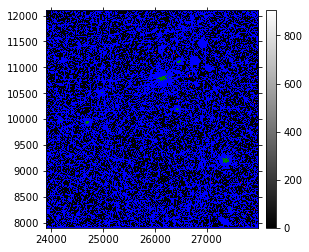

In [22]:
display = afwDisplay.Display()

display.setDefaultMaskTransparency(0)
display.mtv(objE2E)

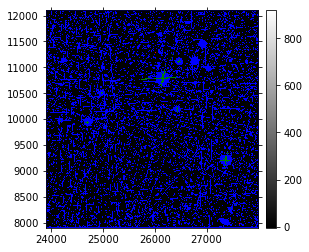

In [23]:
display = afwDisplay.Display()

display.setDefaultMaskTransparency(0)
display.mtv(objReg)